In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA

# Data exploration

In [2]:
data = pd.read_csv("newdata3.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
data.info()
#no duplicates
#data = data.drop_duplicates(subset = ['weight_16', 'height_16'])
#data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weight_16          5351 non-null   float64
 1   height_16          5364 non-null   float64
 2   iq                 7288 non-null   float64
 3   dep_band_15        5299 non-null   float64
 4   anx_band_15        5303 non-null   float64
 5   exercise           4971 non-null   float64
 6   child_bull         4989 non-null   float64
 7   has_dep_diag       4513 non-null   float64
 8   secd_diag          4513 non-null   float64
 9   prim_diag          4513 non-null   float64
 10  panic_score        4513 non-null   float64
 11  dep_thoughts       1805 non-null   float64
 12  dep_score          4513 non-null   float64
 13  comp_house         13734 non-null  float64
 14  alon               4837 non-null   float64
 15  draw               4827 non-null   float64
 16  musi               481

<AxesSubplot:>

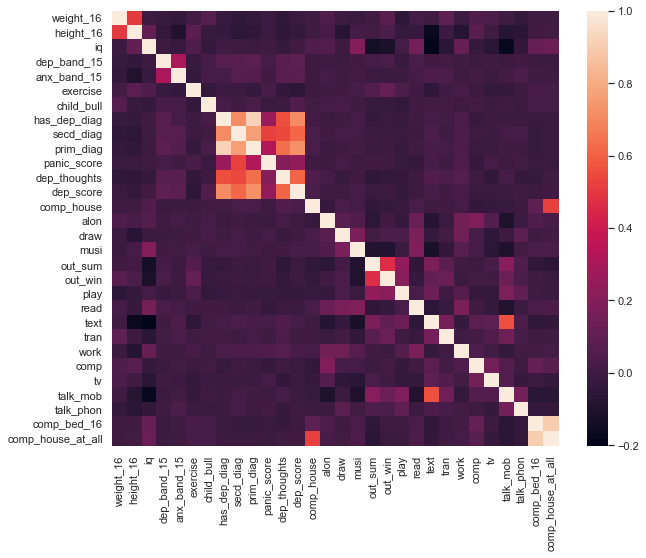

In [4]:
sns.set(rc = {'figure.figsize':(10, 8)})
sns.heatmap(data.corr())

<AxesSubplot:xlabel='level_0', ylabel='level_1'>

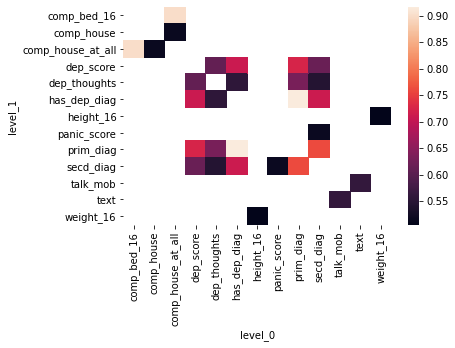

In [3]:
#getting rid of obvious correlations

s = data.corr().abs().unstack()
high = s.sort_values()

for i in high.index:
    split1 = i[0].rstrip('we k nd')
    split2 = i[1].rstrip('we k nd')
    split1 = split1.rstrip('_')
    split2 = split2.rstrip('_')
    if split1 == i[1] or split2 == i[0] or split1 == split2:
        high[i[0], i[1]] = 2
        
high = high[high >= 0.5]
high = high[high < 1]
high = high.to_frame().reset_index()
corr = pd.pivot_table(high, columns = ['level_0'], values = 0, index = ['level_1'])
sns.heatmap(corr)

<AxesSubplot:>

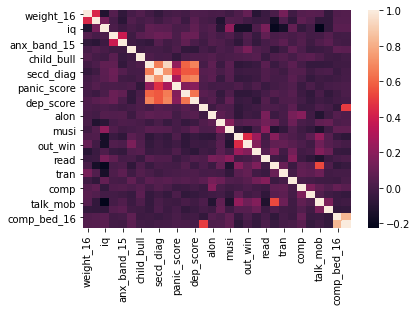

In [4]:
#target variables
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

#keeping rows with no missing data
full = data.dropna(axis = 0, how = 'any')
sns.heatmap(full.corr())

## Logistic Regression and PCA

In [13]:
#attempt at mitigating imbalanced data
lim = 8
no_dep = full.query('prim_diag in [4,10, 11, 12]')
has_dep = full.query('prim_diag not in [4,10, 11, 12]')

sample = no_dep.sample(n = 150, random_state = 1)
sample2 = has_dep.sample(n = 150, random_state = 1)

fullSample = sample.append(sample2)

In [14]:
#input variables
X = fullSample.drop(dep[1:-1], axis = 1)

In [15]:
#using logistic regression on X and X_pca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pca = PCA(0.9)

#error for dep_band_15 since its continous so i dropped it
for i in dep[1:-1]:
    y = fullSample[i]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = 0.2, random_state = 30)

    model = LogisticRegression(max_iter = 10000)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    X_pca = pca.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 30)
    
    model2 = LogisticRegression(max_iter = 10000)
    model2.fit(X_train, y_train)
    score2 = model2.score(X_test, y_test)
    print(i, score, score2)

has_dep_diag 0.8 0.5
secd_diag 0.5166666666666667 0.5
prim_diag 0.45 0.31666666666666665
panic_score 0.95 0.9333333333333333
dep_thoughts 0.38333333333333336 0.3333333333333333


In [16]:
pca.explained_variance_ratio_

array([0.4351094 , 0.22611592, 0.17646326, 0.06018434, 0.0502073 ])

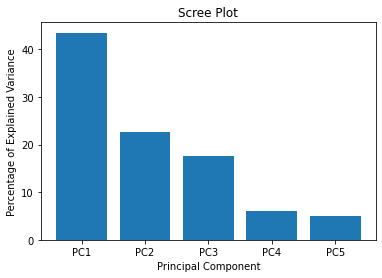

In [17]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

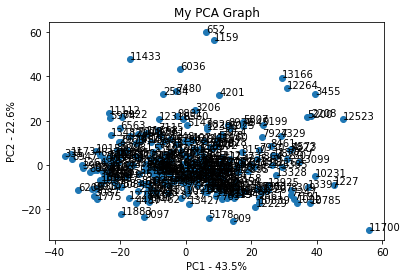

In [18]:
#??
pca_df = pd.DataFrame(X_pca, index = X.index, columns = labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1])) 
for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

In [19]:
#more pca
pca2 = PCA(n_components=2)
pca2.fit_transform(X)
print(pca2.explained_variance_ratio_)

[0.4351094  0.22611592]


original shape:    (300, 25)
transformed shape: (300, 2)


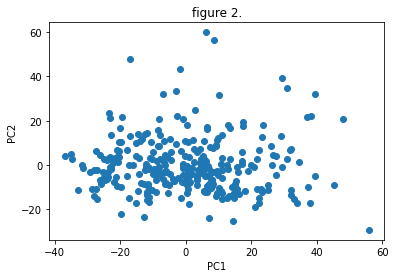

In [20]:
X_pca = pca2.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1)
#for sample in pca2.index:
 #   plt.annotate(sample, (pca2.PC1.loc[sample], pca2.PC2.loc[sample]))
plt.title("figure 2.")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('auto');


## K-Means

In [21]:
from sklearn.cluster import KMeans

In [22]:
def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.axis('auto')
    plt.viridis()
    plt.scatter(X[:, 0], X[:, 1], s=20, c=cluster_assignments, alpha=0.9)
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=200, marker='X', c=range(K), edgecolors='k')
    plt.title("figure 3.")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()



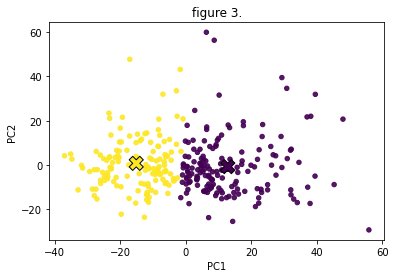

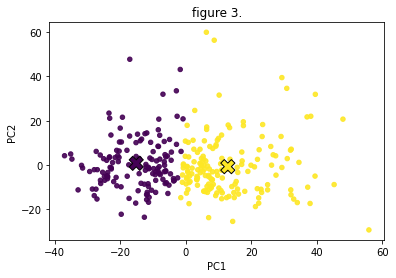

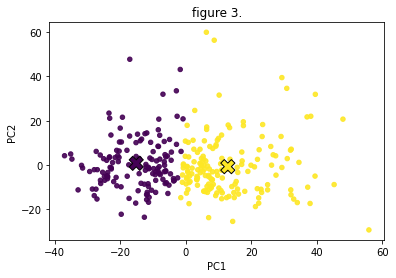

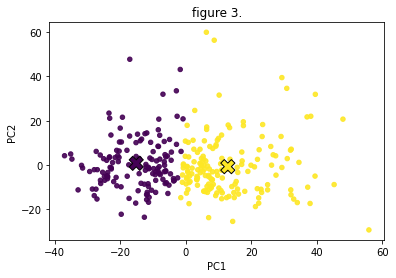

In [23]:
K = 2
kmeans = KMeans(K, init='random').fit(X_pca)
cluster_assignments = kmeans.predict(X_pca)
centroid_locations = kmeans.cluster_centers_
plot_k_means(X_pca, cluster_assignments, centroid_locations)

kmeans1 = KMeans(K).fit(X_pca)
cluster_assignments1 = kmeans1.predict(X_pca)
centroid_locations1 = kmeans1.cluster_centers_
plot_k_means(X_pca, cluster_assignments1, centroid_locations1)

kmeans2 = KMeans(K, init='random', max_iter = 2000).fit(X_pca)
cluster_assignments2 = kmeans2.predict(X_pca)
centroid_locations2 = kmeans2.cluster_centers_
plot_k_means(X_pca, cluster_assignments2, centroid_locations2)

kmeans3 = KMeans(K, init='random', n_init = 200).fit(X_pca)
cluster_assignments3 = kmeans3.predict(X_pca)
centroid_locations3 = kmeans3.cluster_centers_
plot_k_means(X_pca, cluster_assignments3, centroid_locations2)

## Gaussian Mixture Model

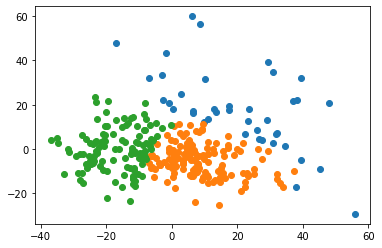

In [24]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

X = X_pca
model = GaussianMixture(n_components=3)
model.fit(X)
yhat = model.predict(X)
clusters = unique(yhat)
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

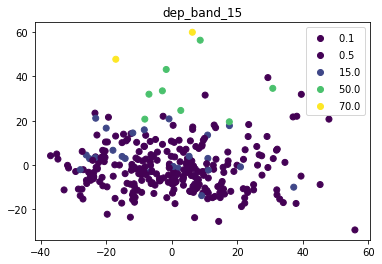

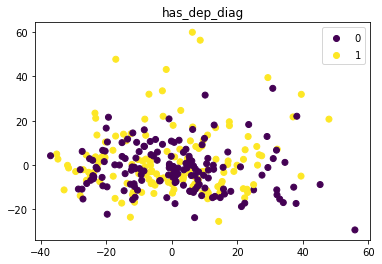

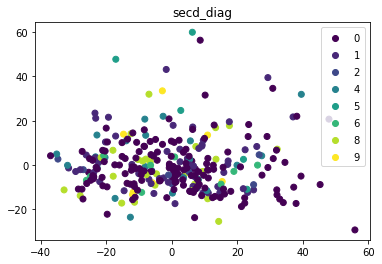

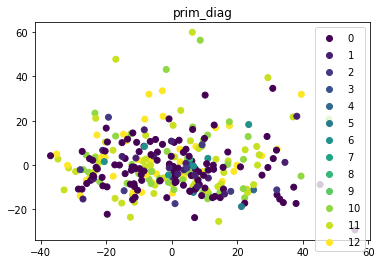

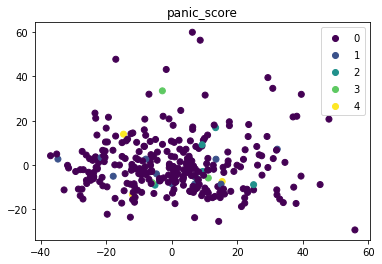

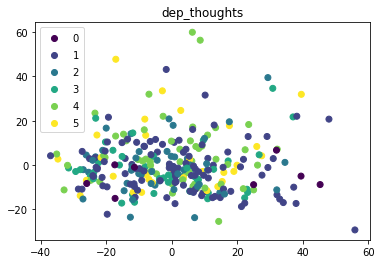

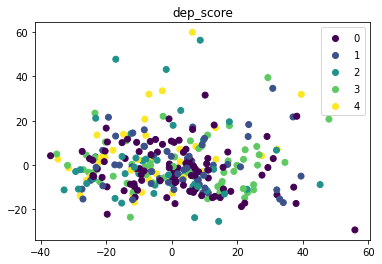

In [25]:
#comparing to data split on target variables

for i in dep:
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=1, c = fullSample[i], cmap = 'viridis')
    plt.legend(*scatter.legend_elements())
    plt.title(i)
    plt.show()

array([[<AxesSubplot:title={'center':'weight_16'}>,
        <AxesSubplot:title={'center':'height_16'}>,
        <AxesSubplot:title={'center':'iq'}>,
        <AxesSubplot:title={'center':'dep_band_15'}>,
        <AxesSubplot:title={'center':'anx_band_15'}>],
       [<AxesSubplot:title={'center':'exercise'}>,
        <AxesSubplot:title={'center':'child_bull'}>,
        <AxesSubplot:title={'center':'has_dep_diag'}>,
        <AxesSubplot:title={'center':'secd_diag'}>,
        <AxesSubplot:title={'center':'prim_diag'}>],
       [<AxesSubplot:title={'center':'panic_score'}>,
        <AxesSubplot:title={'center':'dep_thoughts'}>,
        <AxesSubplot:title={'center':'dep_score'}>,
        <AxesSubplot:title={'center':'comp_house'}>,
        <AxesSubplot:title={'center':'alon'}>],
       [<AxesSubplot:title={'center':'draw'}>,
        <AxesSubplot:title={'center':'musi'}>,
        <AxesSubplot:title={'center':'out_sum'}>,
        <AxesSubplot:title={'center':'out_win'}>,
        <AxesSubplot:t

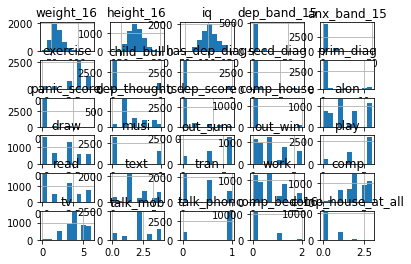

In [26]:
data.hist()

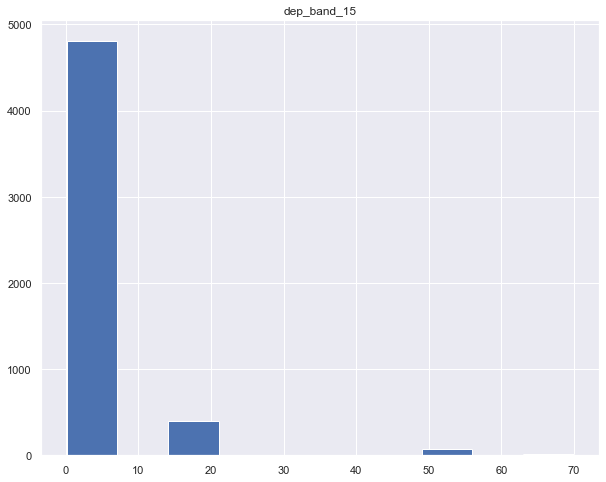

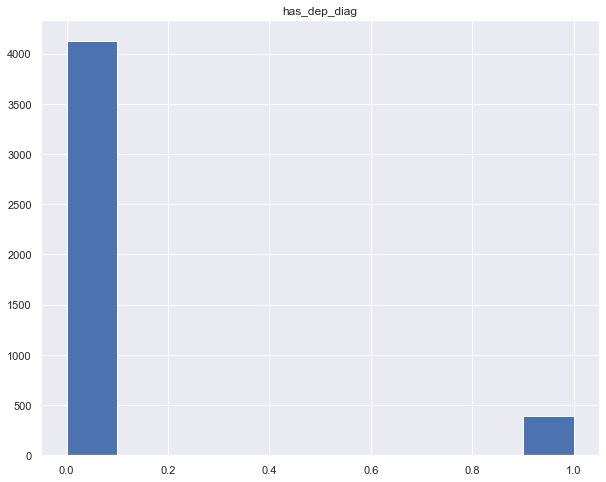

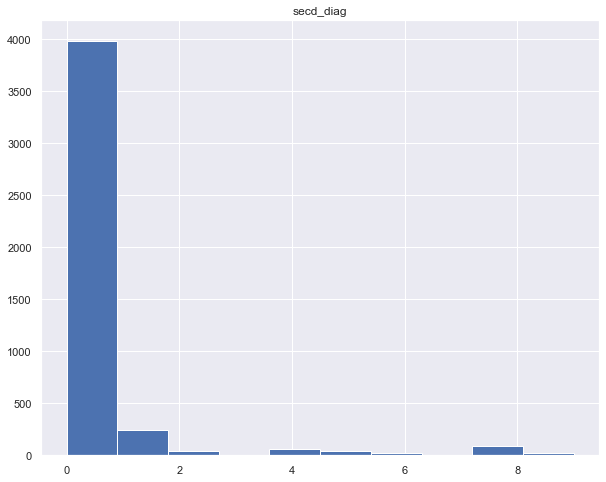

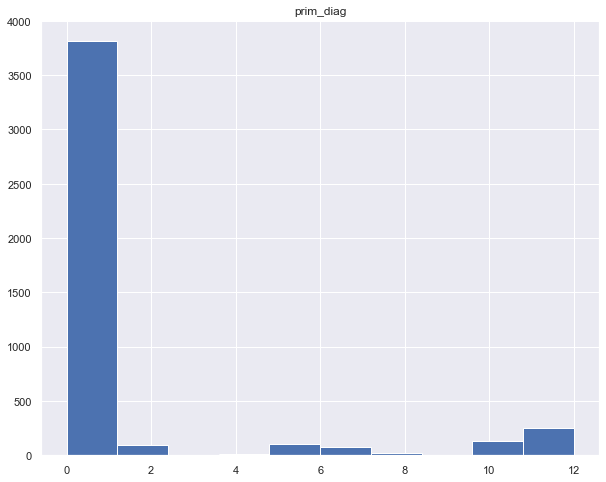

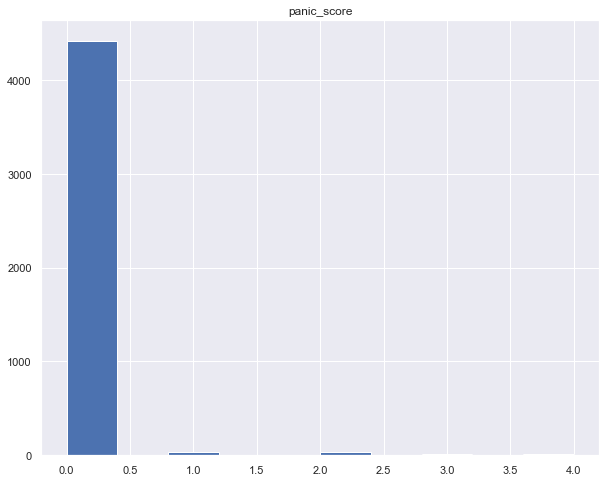

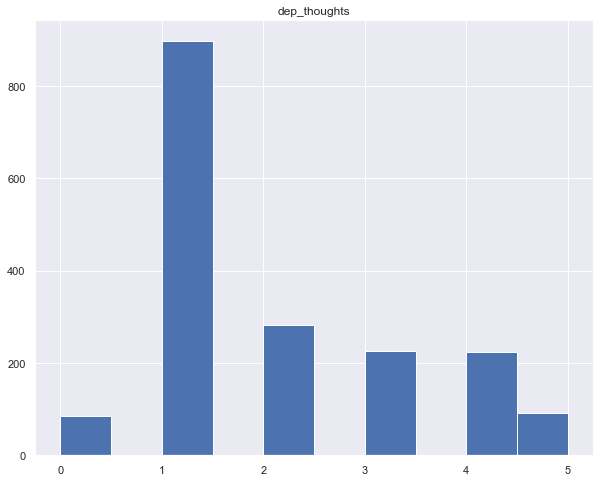

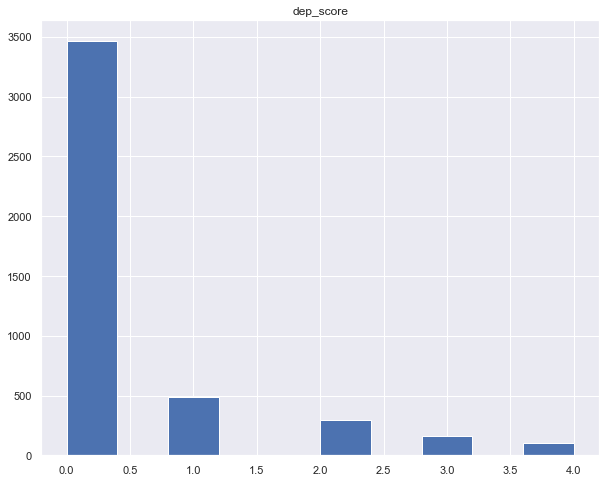

In [22]:
for i in dep:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(data[i])
    plt.title(i)

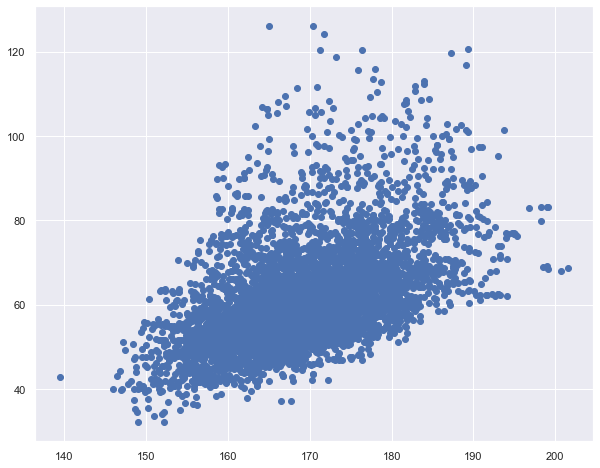

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data['height_16'], data['weight_16'])
